In [22]:
import numpy as np
from qutip import Options
import qutip as qt
import matplotlib.pyplot as plt
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode
from functools import reduce

opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
p_bar = qt.ui.TextProgressBar()  # None

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interactive, Output

# Initial qubit frequencies and SNAIL frequency
freqs = np.array([4, 6, 4.665925])  # q1, q2, q3 frequencies
snail_freq = 5.6675931  # SNAIL frequency


# Adjust qubit frequencies based on a shrink factor
def adjust_frequencies(freqs, snail_freq, shrink_factor):
    # Combine the frequencies and the SNAIL frequency into one array
    all_freqs = np.append(freqs, snail_freq)

    # Calculate the midpoint of all frequencies including the SNAIL frequency
    midpoint = np.mean(all_freqs)

    # Translate all frequencies to the origin (midpoint becomes the new origin)
    translated_freqs = all_freqs - midpoint

    # Apply the shrink factor (scaling about the new origin)
    scaled_freqs = translated_freqs * shrink_factor

    # Translate all frequencies back to the original location
    adjusted_freqs = scaled_freqs + midpoint

    # Separate the qubit frequencies from the SNAIL frequency
    adjusted_qubit_freqs = adjusted_freqs[:-1]
    adjusted_snail_freq = adjusted_freqs[-1]

    return adjusted_qubit_freqs, adjusted_snail_freq

In [24]:
# Initial qubit frequencies and SNAIL frequency
freqs = np.array([5.06167, 4.54944, 4.16829])  # q1, q2, q3 frequencies
snail_freq = 4.27515  # SNAIL frequency

adjusted_freqs, adjusted_snail = adjust_frequencies(
    freqs, snail_freq, shrink_factor=1.0
)
adjusted_freqs, adjusted_snail

(array([5.06167, 4.54944, 4.16829]), 4.27515)

In [25]:
qubit_dim = 2
qubit1 = QubitMode(name="q1", dim=qubit_dim, freq=adjusted_freqs[0])
qubit2 = QubitMode(name="q2", dim=qubit_dim, freq=adjusted_freqs[1])
qubit3 = QubitMode(name="q3", dim=qubit_dim, freq=adjusted_freqs[2])
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(name="s", freq=adjusted_snail, g3=0.3, dim=10, T1=1e3, T2=5e2)

# define couplings so hybridizations are all equal
# g/delta = 0.1 for all qubits
g2_0 = 0.1 * np.abs(snail.freq - qubit1.freq)
g2_1 = 0.1 * np.abs(snail.freq - qubit2.freq)
g2_2 = 0.1 * np.abs(snail.freq - qubit3.freq)
_couplings = {
    frozenset([qubit1, snail]): g2_0,
    frozenset([qubit2, snail]): g2_1,
    frozenset([qubit3, snail]): g2_2,
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

In [44]:
# Step 1. construct the linear Hamiltonian
HL = 0
# HL += snail.freq * qs.modes_num[snail]
# for q in qubits:
#     HL -= q.freq * (qs.modes_Z[q] / 2)
for m in qs.modes:
    HL += m.freq * qs.modes_num[m]

# Step 2. add the SNAIL non-linearity
HNL = snail.g3 / 6 * (qs.modes_field[snail]) ** 3
for q in qubits:
    HNL += q.alpha / 12 * (qs.modes_num[q]) ** 4

# Step 3. Add the coupling terms
Hc = 0
for c, g in qs.couplings.items():
    q1, q2 = c
    Hc += g * (qs.modes_field[q1] * qs.modes_field[q2])

# Total Hamiltonian
H0 = HL + HNL + Hc

# pump_term = qs.modes_a_dag[snail] - qs.modes_a[snail]
pump_term = qs.modes_a_dag[snail] + qs.modes_a[snail]

In [45]:
H0

Quantum object: dims = [[2, 2, 2, 10], [2, 2, 2, 10]], shape = (80, 80), type = oper, isherm = True
Qobj data =
[[  0.           0.9424778    0.         ...   0.           0.
    0.        ]
 [  0.9424778   26.86155967   2.66572976 ...   0.           0.
    0.        ]
 [  0.           2.66572976  53.72311933 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 274.40916475  21.3258381
    0.        ]
 [  0.           0.           0.         ...  21.3258381  301.27072442
   16.02212253]
 [  0.           0.           0.         ...   0.          16.02212253
  328.13228408]]

In [46]:
from quantum_logical.pulsesim.hamiltonian import Hamiltonian

Hamiltonian(qs).H

Quantum object: dims = [[2, 2, 2, 10], [2, 2, 2, 10]], shape = (80, 80), type = oper, isherm = True
Qobj data =
[[  0.           0.9424778    0.         ...   0.           0.
    0.        ]
 [  0.9424778   26.86155967   2.66572976 ...   0.           0.
    0.        ]
 [  0.           2.66572976  53.72311933 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 274.40916475  21.3258381
    0.        ]
 [  0.           0.           0.         ...  21.3258381  301.27072442
   16.02212253]
 [  0.           0.           0.         ...   0.          16.02212253
  328.13228408]]

In [13]:
# create an initial state
# |0> \otimes |1> \otimes |0> \otimes |0>
psi0 = qs.prepare_tensor_fock_state([(qubit2, 1)])

# search for dressed initial state using the eigenstates of the Hamiltonian
eigenvalues, eigenvectors = H0.eigenstates()
for eigen_index, eigenvector in enumerate(eigenvectors):
    overlap = np.abs(eigenvector.overlap(psi0))
    if overlap > 0.95:
        break
print(f"Found overlap with eigenstate {eigen_index} by {overlap:.4f}")
psi0 = eigenvectors[eigen_index]

# convert to density matrix
rho0 = psi0 * psi0.dag()

Found overlap with eigenstate 3 by 0.9951


In [14]:
desired_U = qt.qip.operations.iswap()  # The iSWAP gate for a 2-qubit system

# Create isometries for qubit 1 and qubit 2 to extend the {g, e} subspace action to the full qubit space
identity_isometry = (
    qt.basis(qubit_dim, 0) * qt.basis(2, 0).dag()
    + qt.basis(qubit_dim, 1) * qt.basis(2, 1).dag()
)
identity_isometry = qt.tensor(identity_isometry, identity_isometry)

# Apply the isometry to extend the gate action
extended_q1_q2 = identity_isometry * desired_U * identity_isometry.dag()

# Tensor with identity matrices for the remaining qubits and the SNAIL mode
for mode in qs.modes[2:]:  # Skip the first two qubits as they're already included
    extended_q1_q2 = qt.tensor(extended_q1_q2, qt.qeye(mode.dim))

# The extended_iswap_q1_q2 now acts as the desired iSWAP gate on {g, e} of qubits 1 and 2, and as identity on the rest
desired_U = extended_q1_q2

expected_rho = qt.Qobj(desired_U * rho0 * desired_U.dag())

In [15]:
# (dressed) expectation operators
e_ops = [qs.modes_num[m] for m in qs.modes]

# collapse operators
c_ops = []
# for mode in qs.modes:
# c_ops.append(mode.collapse_operators(qs))

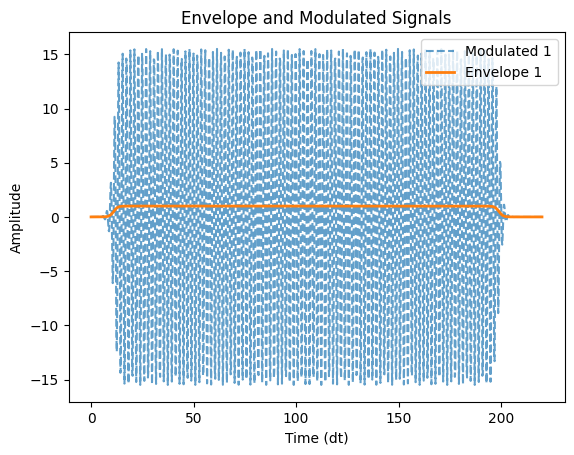

In [16]:
# Step 3. construct the pump term
# Experiment constants
width_d = 200
N = 15
detuning_range = (0.00825, 0.009)  # in GHz
amp_range = (15, 16)
# Convert GHz to MHz
detuning_flist = np.linspace(detuning_range[0], detuning_range[1], N) * 1000
# Conversion to radian frequency
flist = 2 * np.pi / 1000 * (detuning_flist) + abs(qubit1.freq - qubit2.freq)
alist = np.linspace(amp_range[0], amp_range[1], N)
t_list = np.linspace(0, 20 + width_d, 1000)  # Time vector for simulations

args = {"shape": Pulse.smoothbox, "shape_params": {"t0": 5, "width": width_d}}

# plot an example pulse from the experiment to verify its shape
omega_p = flist[int(N / 2)]
amp_p = alist[int(N / 2)]
pulse = Pulse(omega=omega_p, amp=amp_p)
Pulse.plot_pulse([(pulse, args)], t_list)

In [17]:
def simulation_task(params):
    freq, amp = params
    pulse = Pulse(omega=freq, amp=amp)
    H_pump = [pump_term, pulse.drive]
    H = [H0, H_pump]
    solve_result = qt.mesolve(H, psi0, t_list, c_ops, args=args, options=opts)
    final_state = solve_result.states[-1]
    fidelity = qt.fidelity(expected_rho, final_state)
    return freq, amp, fidelity

In [35]:
# Preparing frequency-amplitude pairs
freq_amp_pairs = [(f, a) for f in flist for a in alist]

# Run simulations in parallel
results = qt.parallel.parallel_map(simulation_task, freq_amp_pairs, progress_bar=True)

KeyboardInterrupt: 

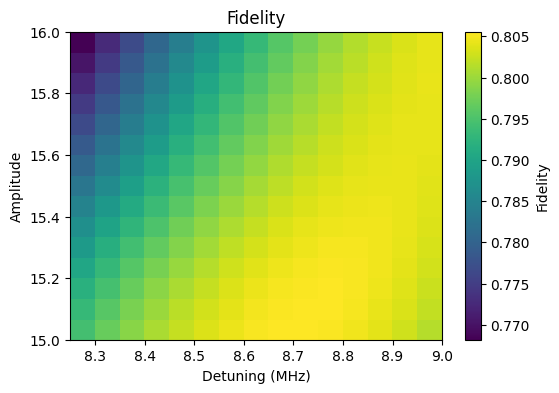

Max fidelity: 0.8056 at Frequency: 3.2733 GHz and Amplitude: 15.0000


In [13]:
# Initialize the fidelity matrix
fidelity_matrix = np.zeros((N, N))

# Fill the fidelity matrix with results
for freq, amp, fidelity in results:
    freq_idx = np.searchsorted(flist, freq)
    amp_idx = np.searchsorted(alist, amp)
    fidelity_matrix[amp_idx, freq_idx] = fidelity

# Plotting fidelity
fig, ax = plt.subplots(figsize=(6, 4))
cax = ax.imshow(
    fidelity_matrix,
    interpolation="nearest",
    cmap="viridis",
    extent=[detuning_flist[0], detuning_flist[-1], alist[0], alist[-1]],
    origin="lower",
    aspect="auto",
)
ax.set_title("Fidelity")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Amplitude")
fig.colorbar(cax, label="Fidelity")
plt.show()

# Identifying optimal parameters for maximum fidelity
max_fid_idx = np.unravel_index(
    np.argmax(fidelity_matrix, axis=None), fidelity_matrix.shape
)

max_fidelity_amp = alist[max_fid_idx[0]]
max_fidelity_freq = flist[max_fid_idx[1]]

print(
    f"Max fidelity: {fidelity_matrix[max_fid_idx]:.4f} at Frequency: {max_fidelity_freq:.4f} GHz and Amplitude: {max_fidelity_amp:.4f}"
)


Starting optimization stage 1
Detuning range (MHz): -10 to 10
Amplitude range: 10 to 30


12.0%. Run time:   6.61s. Est. time left: 00:00:00:48
20.0%. Run time:   9.02s. Est. time left: 00:00:00:36
32.0%. Run time:   9.45s. Est. time left: 00:00:00:20
40.0%. Run time:  11.04s. Est. time left: 00:00:00:16
52.0%. Run time:  14.61s. Est. time left: 00:00:00:13
60.0%. Run time:  16.05s. Est. time left: 00:00:00:10
72.0%. Run time:  17.83s. Est. time left: 00:00:00:06
80.0%. Run time:  18.27s. Est. time left: 00:00:00:04
92.0%. Run time:  19.56s. Est. time left: 00:00:00:01
100.0%. Run time:  21.30s. Est. time left: 00:00:00:00
Total run time:  21.31s


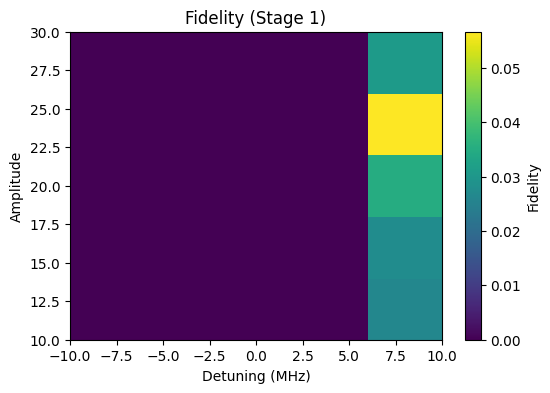

Best fidelity: 0.0567 at Detuning: 10.0 MHz and Amplitude: 25.0

Starting optimization stage 2
Detuning range (MHz): 5.0 to 15.0
Amplitude range: 20.0 to 30.0
12.0%. Run time:   9.01s. Est. time left: 00:00:01:06
20.0%. Run time:   9.16s. Est. time left: 00:00:00:36
32.0%. Run time:  10.07s. Est. time left: 00:00:00:21
40.0%. Run time:  11.80s. Est. time left: 00:00:00:17
52.0%. Run time:  17.66s. Est. time left: 00:00:00:16
60.0%. Run time:  17.89s. Est. time left: 00:00:00:11
72.0%. Run time:  18.32s. Est. time left: 00:00:00:07
80.0%. Run time:  19.68s. Est. time left: 00:00:00:04
92.0%. Run time:  20.86s. Est. time left: 00:00:00:01
100.0%. Run time:  23.28s. Est. time left: 00:00:00:00
Total run time:  23.30s


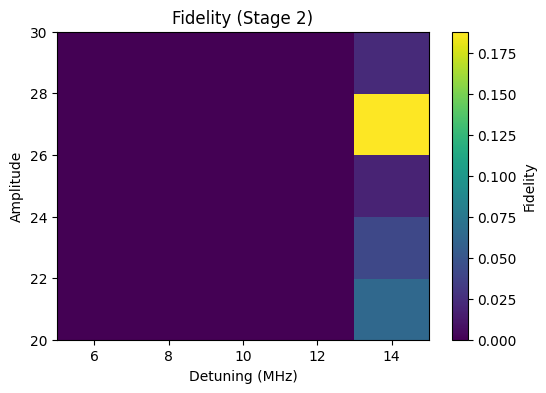

Best fidelity: 0.1877 at Detuning: 15.0 MHz and Amplitude: 27.5

Starting optimization stage 3
Detuning range (MHz): 10.0 to 20.0
Amplitude range: 22.5 to 32.5
12.0%. Run time:   8.91s. Est. time left: 00:00:01:05
20.0%. Run time:   9.30s. Est. time left: 00:00:00:37
32.0%. Run time:   9.79s. Est. time left: 00:00:00:20
40.0%. Run time:  12.05s. Est. time left: 00:00:00:18
52.0%. Run time:  17.92s. Est. time left: 00:00:00:16
60.0%. Run time:  18.52s. Est. time left: 00:00:00:12
72.0%. Run time:  18.71s. Est. time left: 00:00:00:07
80.0%. Run time:  19.17s. Est. time left: 00:00:00:04
92.0%. Run time:  21.51s. Est. time left: 00:00:00:01
100.0%. Run time:  23.56s. Est. time left: 00:00:00:00
Total run time:  23.58s


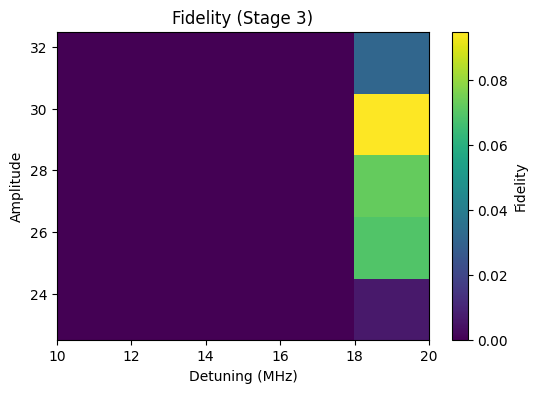

Best fidelity: 0.0949 at Detuning: 20.0 MHz and Amplitude: 30.0


In [14]:
# Experiment constants
width_d = 150
N_initial = 5  # Start with a small number of points for the detuning sweep
t_list = np.linspace(0, 20 + width_d, 1000)  # Time vector for simulations

args = {"shape": Pulse.smoothbox, "shape_params": {"t0": 5, "width": width_d}}

# Initial detuning (in MHz) and amplitude ranges for the first sweep
detuning_range_mhz = (-10, 10)  # Detuning range in MHz
amp_range = (10, 30)  # Amplitude range

# Calculate the base conversion frequency (difference between qubit frequencies in GHz)
conversion_freq_ghz = abs(qubit1.freq - qubit2.freq)

num_stages = 3

for stage in range(num_stages):
    print(f"\nStarting optimization stage {stage+1}")
    print(f"Detuning range (MHz): {detuning_range_mhz[0]} to {detuning_range_mhz[1]}")
    print(f"Amplitude range: {amp_range[0]} to {amp_range[1]}")

    detuning_flist_mhz = np.linspace(
        detuning_range_mhz[0], detuning_range_mhz[1], N_initial
    )
    alist = np.linspace(
        amp_range[0], amp_range[1], N_initial
    )  # Ensure alist is defined in each iteration
    flist = (
        2 * np.pi * (detuning_flist_mhz / 1000 + conversion_freq_ghz)
    )  # Convert to radians

    # Run simulations in parallel
    freq_amp_pairs = [(f, a) for f in flist for a in alist]
    results = qt.parallel.parallel_map(
        simulation_task, freq_amp_pairs, progress_bar=True
    )

    # Process results and plot
    fidelity_matrix = np.zeros((N_initial, N_initial))
    for detuning_mhz, amp, fidelity in results:
        detuning_idx = np.searchsorted(detuning_flist_mhz, detuning_mhz)
        amp_idx = np.searchsorted(alist, amp)
        # Ensure indices are within bounds
        detuning_idx = min(detuning_idx, N_initial - 1)
        amp_idx = min(amp_idx, N_initial - 1)
        fidelity_matrix[amp_idx, detuning_idx] = fidelity

    plt.figure(figsize=(6, 4))
    plt.imshow(
        fidelity_matrix,
        interpolation="nearest",
        cmap="viridis",
        extent=[detuning_flist_mhz[0], detuning_flist_mhz[-1], alist[0], alist[-1]],
        origin="lower",
        aspect="auto",
    )
    plt.title(f"Fidelity (Stage {stage + 1})")
    plt.xlabel("Detuning (MHz)")
    plt.ylabel("Amplitude")
    plt.colorbar(label="Fidelity")
    plt.show()

    max_fid_idx = np.unravel_index(
        np.argmax(fidelity_matrix, axis=None), fidelity_matrix.shape
    )
    best_detuning_mhz = detuning_flist_mhz[max_fid_idx[1]]
    best_amp = alist[max_fid_idx[0]]

    print(
        f"Best fidelity: {fidelity_matrix[max_fid_idx]:.4f} at Detuning: {best_detuning_mhz} MHz and Amplitude: {best_amp}"
    )

    # Narrow down the search around the best parameters found for the next stage
    detuning_range_mhz = (best_detuning_mhz - 5, best_detuning_mhz + 5)
    amp_range = (best_amp - 5, best_amp + 5)

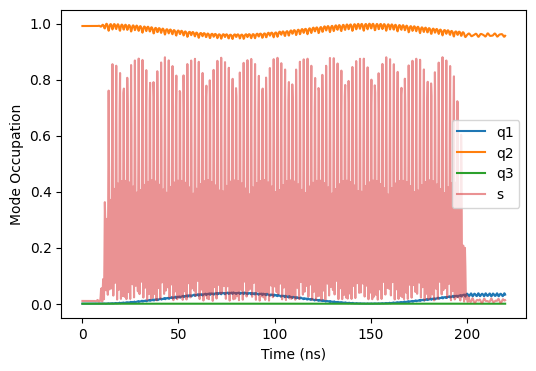

In [19]:
# Rerun the simulation with the optimal parameters
pulse = Pulse(omega=abs(qubit1.freq - qubit2.freq), amp=20)
H_pump = [pump_term, pulse.drive]
H = [H0, H_pump]
solve_result = qt.mesolve(H, psi0, t_list, args=args, options=opts, e_ops=e_ops)

# Plot the state evolution (<n> vs time) for each mode (one plot total)
fig, ax = plt.subplots(figsize=(6, 4))
for k, mode in enumerate(qs.modes):
    ax.plot(
        t_list, solve_result.expect[k], label=mode.name, alpha=(0.5 if k == 3 else 1)
    )
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Mode Occupation")
ax.legend()
plt.show()

In [ ]:
# instead of <n>, can we make separate plots for <g>, <e>, and <f>?

# Rerun the simulation with the optimal parameters
pulse = Pulse(omega=abs(qubit1.freq - qubit2.freq), amp=20)
H_pump = [pump_term, pulse.drive]
H = [H0, H_pump]
solve_result = qt.mesolve(H, psi0, t_list, args=args, options=opts)

# Plot the state (vs time) for each mode (for each level)
fig, ax = plt.subplots(figsize=(6, 4))
# ???